Парсинг сайта VK Education, предобработка базы знаний

In [2]:
!pip install nest_asyncio xmltodict openai==0.28.0 langchain==0.0.281 tiktoken faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 691.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.1.2
    Uninstalling tenacity-9.1.2:
      Successfully uninstalled tenacity-9.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: openai
    Found existing installation: o

In [3]:
import nest_asyncio
nest_asyncio.apply()
import xmltodict
from langchain.document_loaders.sitemap import SitemapLoader
import requests
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken
import matplotlib.pyplot as plt
import getpass
import os
import openai
from langchain.vectorstores import FAISS
import re

In [4]:
url = "https://education.vk.company/"
url_site_map = f"{url}/sitemap.xml"

sitemap_loader = SitemapLoader(web_path=url_site_map) #filter_urls=filter_urls

In [5]:
text_splitter_instance = RecursiveCharacterTextSplitter(chunk_size = 750, chunk_overlap  = 20,)
docs = sitemap_loader.load_and_split(text_splitter=text_splitter_instance)

Fetching pages: 100%|##########| 346/346 [03:34<00:00,  1.61it/s]


In [6]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

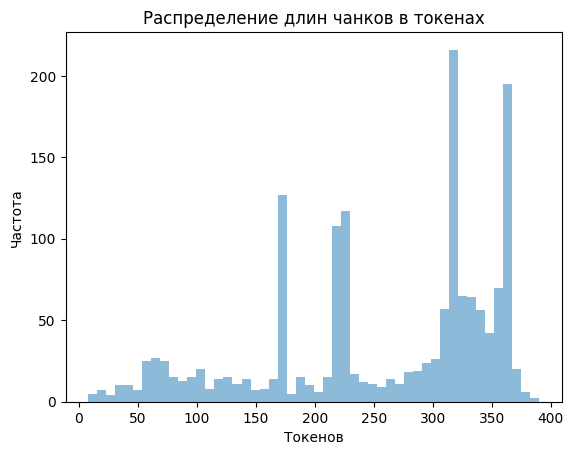

[Document(page_content='VK EducationШкольникамСамое актуальное сейчасПрограммирование для школьниковОбразование с VKПрограммирование для школьниковVK Education в вузахОлимпиады и чемпионатыПрофориентация и карьераIT-дайвингДень it‑знанийТест-драйв IT-профессийСтудентамОбразование с VKКурсыПроекты для студентовПрофориентация и карьераАмбассадоры VKСтажировка в VKДругие возможностиПроекты в креативных индустрияхVK Education в моем вузеОлимпиады и чемпионатыИгровая индустрия в VKСпециалистамВузам и партнерамVK для образовательных учрежденийДругие возможностиПроекты в креативных индустрияхЧемпионаты и соревнованияНовостиКонтактывход / регистрацияШкольникамСтудентамСпециалистамНовостиКонтактыНастоящие знаниядля будущих свершенийПострой свой путь в\xa0IT\xa0и\xa0digitalВыбирай', metadata={'source': 'https://education.vk.company/', 'loc': 'https://education.vk.company/', 'lastmod': '2024-04-23T14:00:00+03:00', 'priority': '1'}), Document(page_content='один из\xa0множества бесплатных образоват

In [7]:
#для отладки
fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in docs]
plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Фрагменты')
plt.title('Распределение длин чанков в токенах')
plt.xlabel('Токенов')
plt.ylabel('Частота')
plt.show()

print(docs[:3], '\n' ,len(docs))

In [ ]:
openai_key = getpass.getpass("OpenAI API Key:")
os.environ["OPENAI_API_KEY"] = openai_key
openai.api_key = openai_key

In [9]:
embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(docs, embeddings)

In [42]:
system="Очень подробно и детально ответь на вопрос пользователя, опираясь точно на документ с информацией для ответа клиенту. Не придумывай ничего от себя. Не ссылайся на сами отрывки документа с информацией для ответа, клиент о них ничего не должен знать. И НИ В КОЕМ СЛУЧАЕ не обсуждай то, что не касается информации из файлов. НЕ ВСТУПАЙ В ДИСКУССИИ НЕ ПО ТЕМЕ."

In [35]:
def answer_index(system, topic, search_index, temp=0, verbose=0) -> str:
    docs = search_index.similarity_search(topic, k=6)
    message_content = re.sub(r'\n{2}', ' ', '\n '.join([
        f'\nОтрывок документа №{i+1}\n=====================\n{doc.page_content}\n'
        for i, doc in enumerate(docs)
    ]))

    if verbose:
        print('message_content:\n', message_content)

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content":
            f"Ответь на вопрос пользователя, но не упоминай данные тебе документы с информацией в ответе. "
            f"Документ с информацией для ответа пользователю: {message_content}\n\n"
            f"Вопрос пользователя:\n{topic}"}
    ]

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=temp
    )

    return completion.choices[0].message.content


def summarize_questions(dialog):
    messages = [
        {"role": "system", "content": "Ты — нейро-саммаризатор. Твоя задача — саммаризировать диалог, который тебе пришёл. "
                                      "Если пользователь назвал своё имя, обязательно отрази его в саммаризированном диалоге."},
        {"role": "user", "content": "Саммаризируй следующий диалог консультанта и пользователя: " + " ".join(dialog)}
    ]

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0
    )

    return completion.choices[0].message.content


def answer_user_question_dialog(system, db, user_question, question_history):
    summarized_history = ""
    if question_history:
        summarized_dialog = summarize_questions([
            f"Пользователь: {q} Консультант: {a}" for q, a in question_history
        ])
        summarized_history = "Вот краткий обзор предыдущего диалога: " + summarized_dialog

    input_text = summarized_history + "\n\nТекущий вопрос: " + user_question
    answer_text = answer_index(system, input_text, db)

    question_history.append((user_question, answer_text if answer_text else ''))

    return answer_text


Работа с VK

In [29]:
!pip install vk_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.9 MB/s eta 0:00:00


In [30]:
def handle_message(event, vk, llm_func, system, db):
    user_id = str(event.user_id)
    message = event.text

    print(f"Сообщение от {user_id}: {message}")
    history = user_histories.setdefault(user_id, [])

    # Получаем ответ
    response = llm_func(system, db, message, history)

    # Отправляем ответ
    vk.messages.send(
        user_id=event.user_id,
        message=response,
        random_id=0
    )

In [31]:
def get_llm_answer(system, db, message, question_history):
    return answer_user_question_dialog(system, db, message, question_history)

In [40]:
import vk_api
from vk_api import VkApi
from vk_api.longpoll import VkLongPoll, VkEventType

TOKEN = ""

# Словарь для хранения истории диалогов
user_histories = {}

def init_vk():
    vk_session = VkApi(token=TOKEN)
    return vk_session.get_api(), VkLongPoll(vk_session)

def main():
    vk, longpoll = init_vk()
    print("бот запущен")

    for event in longpoll.listen():
        if event.type == VkEventType.MESSAGE_NEW and event.to_me and event.text:
            handle_message(event, vk, get_llm_answer, system, db)

if __name__ == "__main__":
    main()


бот запущен
Сообщение от 1042688112: Здравстуйте!
Подскажите, плз, есть ли возможность попасть в штат после выполнения кейса? А еще есть ли кейсы для дизайнеров?
Сообщение от 1042688112: А как обратиться к куратору?
Сообщение от 1042688112: Есть два стула
Сообщение от 1042688112: расскажи прикол


KeyboardInterrupt: 